## Folke Hilding
Explorative notebook

Processing file: ../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst
channels used are [0, 1]
number of bins = [1024, 1024]
auto-bound on X = 716
auto-bound on Y = 1024


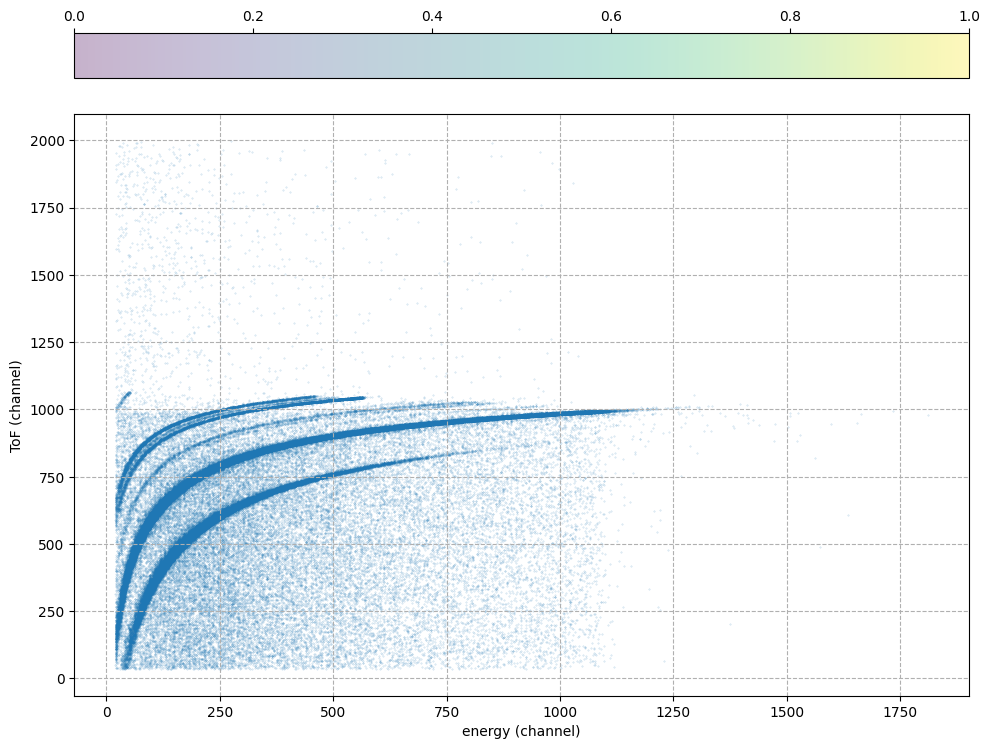

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import math
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import lists
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
header, events, timing = lists.lstRead(FILE_PATH)
chn = [2048,2048]
all_bhist_data = []  # To store results from all files
all_outLists = []
print(f'Processing file: {FILE_PATH}')
header, events, timing = lists.lstRead(FILE_PATH)
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events, coin, zdrop)
# Store outLists for each file for further processing
all_outLists.append(outLists)
binwidth = 2  # Set bin width
bins_x = int(chn[0] / binwidth)
bins_y = int(chn[1] / binwidth)
inds_multi = [ind for ind in range(8) if coin[ind]]
chmin = [0, 0]
chmax = [chn[inds_multi[0]], chn[inds_multi[1]]]
nbins = [chn[inds_multi[0]] + 1, chn[inds_multi[1]] + 1]
nbins = [math.floor(nb / binwidth) for nb in nbins]
bins = [np.linspace(chmin[0], chmax[0], nbins[0]), np.linspace(chmin[1], chmax[1], nbins[1])]
print(f'channels used are {inds_multi}')
print(f'number of bins = {nbins}')
lhist, xed, yed = np.histogram2d(outLists[0], outLists[1], bins=bins)
cut = 4
pro_x = np.zeros(bins_x)
pro_y = np.zeros(bins_y)
for i in range(bins_x - 1):
    pro_x[i] = sum(lhist[i, :])
for i in range(bins_y - 1):
    pro_y[i] = sum(lhist[:, i])
for i in reversed(range(bins_x - 3)):
    if i == 3:
        bound_x = bins_x
        print('no good data found!')
        break
    if sum(pro_x[i - 2:i + 2]) > cut:
        bound_x = int(i * 1.1)
        if bound_x >= bins_x:
            bound_x = bins_x
        break
for i in reversed(range(bins_y - 3)):
    if i == 3:
        bound_y = bins_y
        print('no good data found!')
        break
    if sum(pro_y[i - 2:i + 2]) > cut:
        bound_y = int(i * 1.1)
        if bound_y >= bins_y:
            bound_y = bins_y
        break
print(f'auto-bound on X = {bound_x}')
print(f'auto-bound on Y = {bound_y}')
bhist = lhist[0:bound_x, 0:bound_y]
thresh_x = 2
thresh_y = 2
bthist = deepcopy(bhist)
bthist[0:bound_x, 0:thresh_y] = 0
bthist[0:thresh_x, 0:bound_y] = 0
prot_x = np.zeros(bound_x)
prot_y = np.zeros(bound_y)
for i in range(bound_x - 1):
    prot_x[i] = sum(bthist[i, :])
for i in range(bound_y - 1):
    prot_y[i] = sum(bthist[:, i])
all_bhist_data.append(bthist)
plt.figure(figsize=(10, 8))
plt.scatter(outLists[0], outLists[1], alpha=0.3, s=0.1)
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.tight_layout()

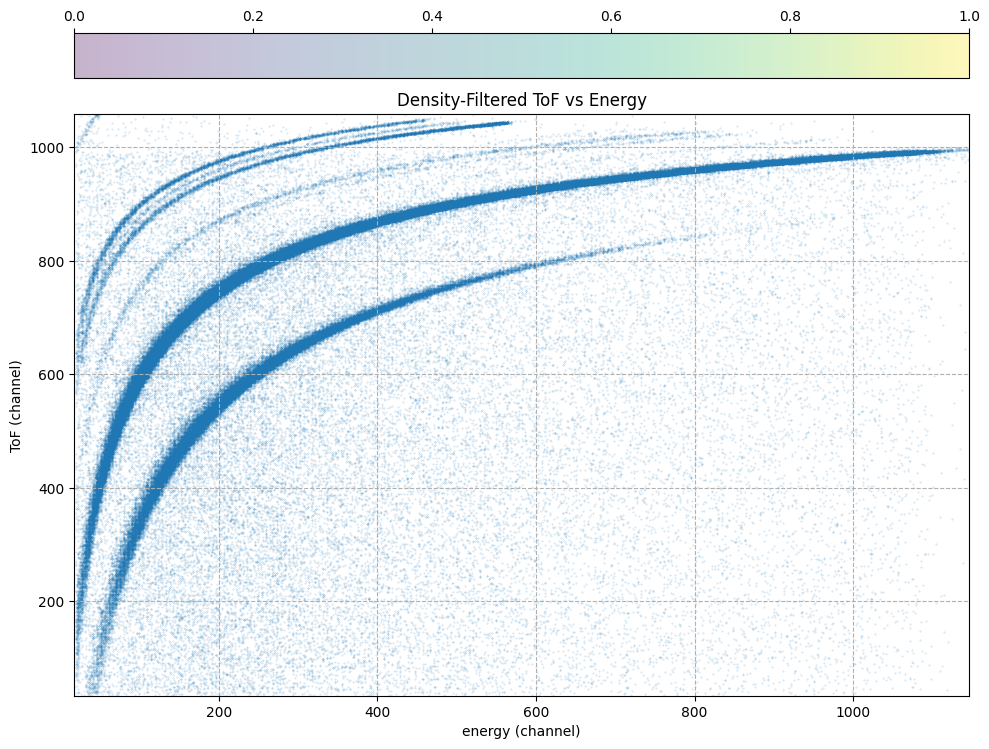

In [5]:
density_threshold = 10

filtered_indices_x = np.where(pro_x > density_threshold)[0]
filtered_indices_y = np.where(pro_y > density_threshold)[0]

x_min, x_max = filtered_indices_x[0], filtered_indices_x[-1]
y_min, y_max = filtered_indices_y[0], filtered_indices_y[-1]

filtered_bhist = bhist[x_min:x_max, y_min:y_max]

plt.figure(figsize=(10, 8))
plt.scatter(outLists[0], outLists[1], alpha=0.3, s=0.1)
plt.xlim([x_min * binwidth, x_max * binwidth])
plt.ylim([y_min * binwidth, y_max * binwidth])
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.title('Density-Filtered ToF vs Energy')
plt.tight_layout()
plt.show()


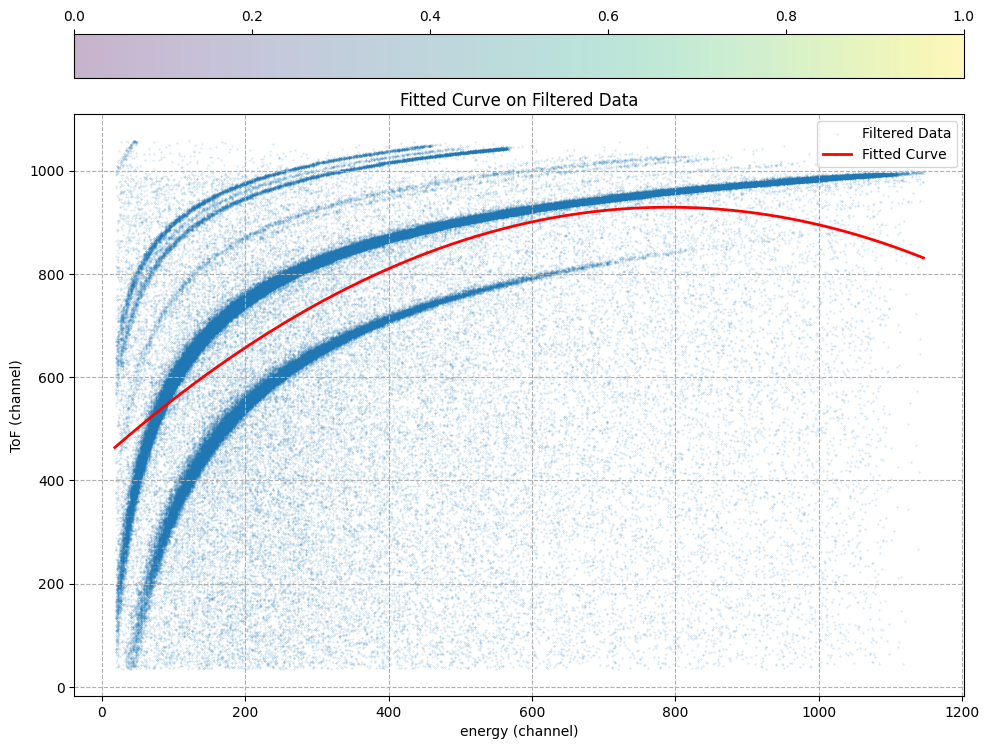

In [9]:
from scipy.optimize import curve_fit

# Ensure outLists elements are NumPy arrays
out_x = np.array(outLists[0])
out_y = np.array(outLists[1])

# Define a polynomial model for fitting
def polynomial_model(x, a, b, c):
    return a * x**2 + b * x + c

# Apply both x and y filtering conditions simultaneously to avoid length mismatch
filtered_indices = (out_x >= x_min * binwidth) & (out_x <= x_max * binwidth) & \
                   (out_y >= y_min * binwidth) & (out_y <= y_max * binwidth)
sample_x = out_x[filtered_indices]
sample_y = out_y[filtered_indices]

# Fit the curve using the polynomial model
popt, _ = curve_fit(polynomial_model, sample_x, sample_y)

# Generate fitted curve points
fitted_x = np.linspace(x_min * binwidth, x_max * binwidth, 500)
fitted_y = polynomial_model(fitted_x, *popt)

# Plot the fitted curve along with the filtered data
plt.figure(figsize=(10, 8))
plt.scatter(sample_x, sample_y, alpha=0.3, s=0.1, label="Filtered Data")
plt.plot(fitted_x, fitted_y, color="red", linewidth=2, label="Fitted Curve")
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.title('Fitted Curve on Filtered Data')
plt.legend()
plt.tight_layout()
plt.show()

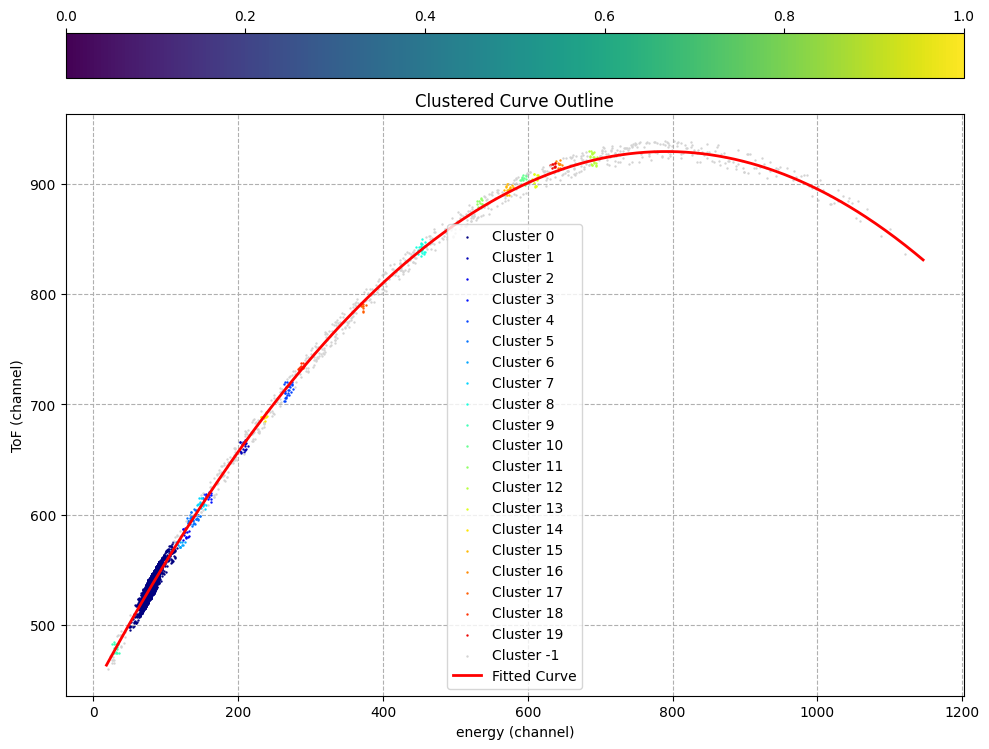

In [10]:
from sklearn.cluster import DBSCAN

# Define a narrow band around the fitted curve for clustering
band_width = 10  # Adjust this width as necessary

# Create a mask for points within the band around the fitted curve
band_mask = np.abs(sample_y - polynomial_model(sample_x, *popt)) < band_width
band_x = sample_x[band_mask]
band_y = sample_y[band_mask]

# Apply DBSCAN clustering within the band
clustering = DBSCAN(eps=5, min_samples=10).fit(np.column_stack((band_x, band_y)))
labels = clustering.labels_

# Plot clustered points along the fitted curve
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        color = "lightgrey"  # Noise
    else:
        color = plt.cm.jet(float(label) / len(unique_labels))
    plt.scatter(band_x[labels == label], band_y[labels == label], color=color, s=0.5, label=f"Cluster {label}")

plt.plot(fitted_x, fitted_y, color="red", linewidth=2, label="Fitted Curve")
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.title('Clustered Curve Outline')
plt.legend()
plt.tight_layout()
plt.show()

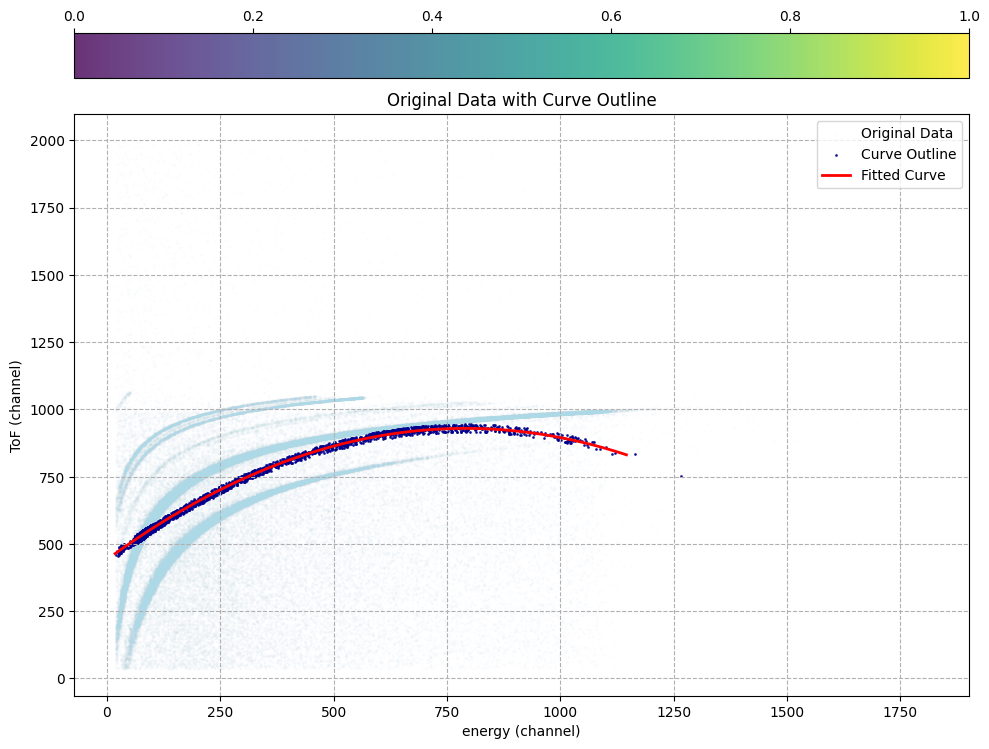

In [11]:
outline_band_width = 15  # Adjust as needed to capture the curve structure

# Mask for points in the original data within the outline band around the fitted curve
outline_mask = np.abs(out_y - polynomial_model(out_x, *popt)) < outline_band_width
outline_x = out_x[outline_mask]
outline_y = out_y[outline_mask]

# Plot the original data with the outline around the curve
plt.figure(figsize=(10, 8))
plt.scatter(outLists[0], outLists[1], alpha=0.1, s=0.1, color="lightblue", label="Original Data")
plt.scatter(outline_x, outline_y, alpha=0.8, s=1.0, color="darkblue", label="Curve Outline")
plt.plot(fitted_x, fitted_y, color="red", linewidth=2, label="Fitted Curve")

# Add color bar and labels
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.title('Original Data with Curve Outline')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

# Adjust DBSCAN parameters for detecting distinct curves in original data
eps = 20  # Distance between points within a cluster (adjust as needed)
min_samples = 50  # Minimum points to form a cluster (adjust as needed)

# Apply DBSCAN clustering on the original data
out_x = np.array(outLists[0])
out_y = np.array(outLists[1])
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(np.column_stack((out_x, out_y)))
labels = clustering.labels_

# Get the unique clusters (ignoring noise with label -1)
unique_clusters = set(labels) - {-1}

# Plot the original data for reference
plt.figure(figsize=(10, 8))
plt.scatter(out_x, out_y, alpha=0.1, s=0.1, color="lightblue", label="Original Data")

# Loop through each cluster to fit and outline each curve
for cluster_id in unique_clusters:
    # Extract points belonging to the current cluster
    cluster_mask = labels == cluster_id
    cluster_x = out_x[cluster_mask]
    cluster_y = out_y[cluster_mask]
    
    # Fit a polynomial to the cluster data
    popt, _ = curve_fit(polynomial_model, cluster_x, cluster_y)
    
    # Generate points along the fitted curve
    fitted_x = np.linspace(cluster_x.min(), cluster_x.max(), 500)
    fitted_y = polynomial_model(fitted_x, *popt)
    
    # Define an outline width for this curve
    outline_band_width = 15  # Adjust to control outline thickness
    
    # Mask original points within the outline band around the fitted curve
    outline_mask = np.abs(out_y - polynomial_model(out_x, *popt)) < outline_band_width
    outline_x = out_x[outline_mask]
    outline_y = out_y[outline_mask]
    
    # Plot the outline for the current curve
    plt.scatter(outline_x, outline_y, alpha=0.8, s=1.0, label=f"Curve Outline {cluster_id}")

# Add color bar, fitted curve, and labels
plt.colorbar(location='top')
plt.grid(linestyle='--')
plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
plt.title('Original Data with Curve Outlines for Each Detected Curve')
plt.legend()
plt.tight_layout()
plt.show()
